In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


K-Means Cluster Analysis (by Stefanie)
-----------------

This notebook is intended to show a process and be descriptive.

In [2]:
# Just for inspecting (and not forgetting about potentially useful information from) the whole joined dataset
df_joineddata = pd.read_csv('joined_data.csv')
df_joineddata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


In [3]:
# Loading extracted poicount data and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s, because having counted no poi in fact IS 0
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)
df_poicount.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Writing the easier to work with df in a new csv file
df_poicount.to_csv(r'poicount.csv', index=False)

In [5]:
# Reading poicount data in as numpy arrays
poicount = np.genfromtxt('poicount.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

Manually inspecting correlations
-----

<AxesSubplot:>

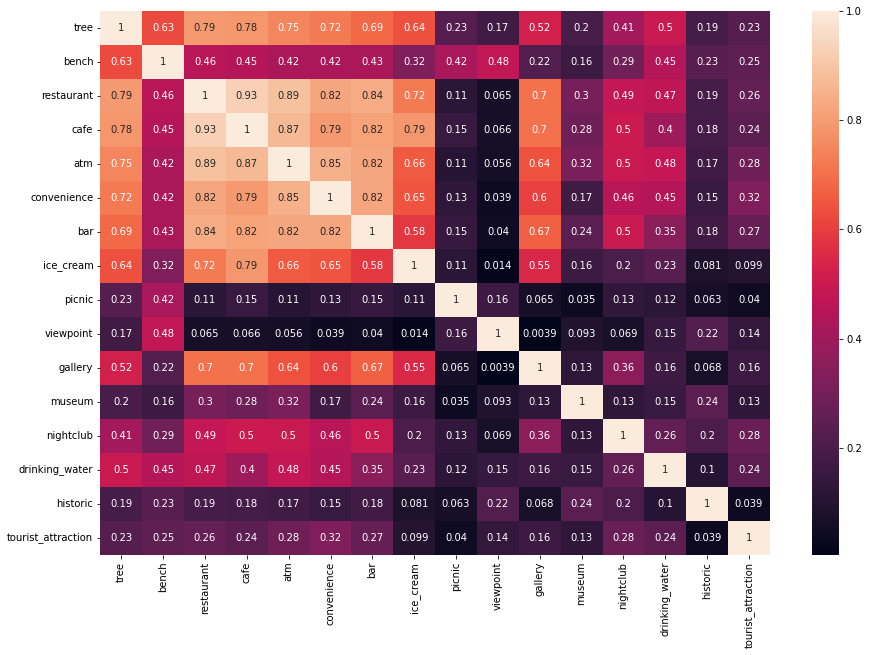

In [6]:
# Getting correlations for all the points of interest (poi)
correlations = df_poicount.iloc[:, 3:].corr()
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(correlations, annot=True)

Observations:

We can see that restaurants, cafes, convenience shops, atms, bars, ice cream shops, galleries, and trees often come along (meaning being on the same route) with each other. It can be suspected that these togeter will form a cluster. (Sometimes, there's also nightclubs and drinking water on these routes.)

Viewpoints and picnic tables don't correlate with most of the other features, not even with each other, which is surprising. But sometimes they come along with benches, which make sense. 

Trees, surprisingly, don't seem to join the nature routes that often, but tend to be on those routes with shops and cafes. 

Tourist attractions and historic sides don't show a clear correlation and seem to be scattered among the other categories (we only have small amounts of those in our dataset though). 

Nightclubs seem to go best with bars, cafes and atms, but no clear correlation here.

Elbow method for finding the optimal k
-----

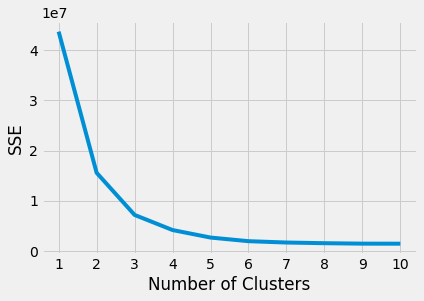

In [42]:
# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# Writing the SSE values for each k into a list
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    sse.append(kmeans.inertia_)

# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2 or 3 clusters will yield the best separation.

In [43]:
# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

3 clusters are made out.

Silhouette method for finding the optimal k
----------------------

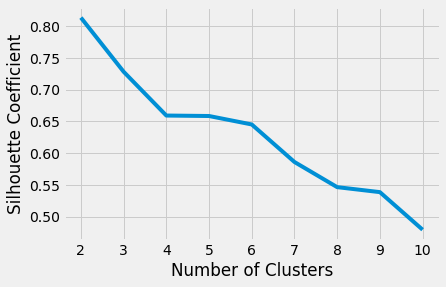

In [44]:
# Making a list for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    score = silhouette_score(poicount, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This would speak for asuming only 2 clusters. In fact, visualisation shows that most of the data is very densely centered, but the silhouette method can only sensefully start at two clusters. By experimenting with the data (not shown here) we found out, that when we'd make three clusters in two clusters, the biggest cluster would "eat" the second biggest, which is a gross loss in information, especially since the biggest cluster is the biggest by far. So, we'll percede with at least 3 clusters.

Cleaning out the noise?
-------

In [45]:
# filtering out any route that pass by more than 500 points of interest             <-- not applied for the reason explained below
#df_poicount = df_poicount.loc[lambda x: x['poi'] < 500]

K-Means is sensitive to outliers. Since our data has a huge variance both along axis 0 and along axis 1, as can be confirmed by looking at the data exploration files in the visualisation folder, there's lot's of outliers to be expected. Also, looking at the 2D visulalisation after dimensionality reduction an the buttom of this notebook, we see that most of the samples cluster densely in a single, small area.

In our data, the uncommon samples (outliers) are those routes, that pass along a large number of different points of interest (features) or, in other words, information-rich routes.

There are three ways to deal with this:

1. we could exclude the outliers and run k-Means with the recommended number of clusters (k) from the elbow or the silhouette method: the clusters would then be found within the dense part of our data, to the cost of losing the "best" routes from our joined dataset.

2. we could keep the outliers and run k-Means with the recommended number of clusters (k) from the elbow or the silhouette method: k-Means would then return one big cluster and some sprinkeled ones with very few elements in each.

3. we could keep the 'noise' and at the same time raise the number of clusters above what elbow or the silhouette method would recommend: that would find more structure even in the very dense part of the data while still including those routes that are very rich in points of interest. This is the solution we adopted.

We would later like to integrate more points of interest data (for the given features) and enrich the existing routes more, so they can spread out.

Unsuccesful first attempt: Implementing k-Means on not standardised feature data
------------------------------------------------------------------------------------------------------------------------------------

In [46]:
# Calculating the percentage of the feature "tree", thus reminding us of what's special about our dataset
print('Trees make out by far the largest amount in our data.', df_poicount['tree'].sum()/df_poicount.iloc[:, 3:].sum().sum()*100, "% of our points of interest is trees.")

Trees make out by far the largest amount in our data. 79.83184053389533 % of our points of interest is trees.


For the high percentage of trees in our data,  will see, that going without standarsisation doesn't fit our purpose.

In [47]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=6, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poicount)

# Getting lables for later mapping these to our dataframe
label = kmeans.labels_

In [48]:
# Lookong at the statistical summaries
print('Lowest SSE value:', kmeans.inertia_, '; that high number is to be expected, because we have only 430 samples lost in 16 dimensions.')
print('Number of iterations required to converge:', kmeans.n_iter_, 'iterations')
print('Looking at the first 20 cluster assignments:', kmeans.labels_[:20])

Lowest SSE value: 1970453.7813721495 ; that high number is to be expected, because we have only 430 samples lost in 16 dimensions.
Number of iterations required to converge: 41 iterations
Looking at the first 20 cluster assignments: [4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 5 4 4]


In [49]:
# Checking how many times each label appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 14, 1: 48, 2: 19, 3: 3, 4: 274, 5: 72}

One cluster holds by far most of the routes in it. By raising k over 3 though, we found some subclusters within that very dense centre.

In [50]:
# Assigning the found cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,1212.357143,107.285714,37.857143,22.928571,9.500000,4.785714,6.000000,1.642857,1.642857,1.285714,1.571429,1.071429,1.642857,1.428571,0.357143,0.214286
1,378.458333,55.187500,13.208333,7.625000,3.020833,3.104167,2.458333,1.062500,0.437500,0.729167,0.416667,0.520833,0.583333,0.375000,0.250000,0.250000
2,647.631579,56.473684,21.947368,12.368421,4.894737,4.368421,4.157895,2.052632,1.157895,0.526316,1.210526,0.631579,0.263158,0.421053,0.157895,0.052632
3,2304.000000,149.333333,90.333333,57.666667,28.333333,31.333333,22.333333,9.000000,1.666667,0.666667,6.000000,0.666667,2.333333,2.333333,0.666667,1.000000
4,21.368613,10.474453,2.087591,1.040146,0.394161,0.226277,0.237226,0.102190,0.284672,0.273723,0.094891,0.105839,0.051095,0.069343,0.051095,0.051095
5,173.875000,30.263889,8.319444,4.861111,1.972222,1.250000,1.791667,0.597222,0.583333,0.347222,0.375000,0.527778,0.402778,0.222222,0.180556,0.097222


In [51]:
# Comments on the cluster dataframe
max_value = max(dict(zip(unique, counts)).values())
max_keys = [k for k, v in dict(zip(unique, counts)).items() if v == max_value]
print('Obviously, "cluster', max_keys, '" stands out for its high procimity to 0! It is the largest cluster and forms a dense centre. It contains routes that pass by only few points of interest.')

Obviously, "cluster [4] " stands out for its high procimity to 0! It is the largest cluster and forms a dense centre. It contains routes that pass by only few points of interest.


Inspecting clusters from unstandardised k-Means approach a bit more:

In [52]:
# Mapping our labels into our dataframe (each route gets a cluster label)
df_poicount_cluster = pd.concat([df_poicount, pd.DataFrame({'cluster':label})], join='inner', axis=1)
df_poicount_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [53]:
# Inspecting clusters
df_clusterinspect = df_poicount_cluster[df_poicount_cluster['cluster'] == 0] # substituting the cluster we're interested in
df_clusterinspect.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
142,3595999,119,1298,1258,6,21,5,2,2,3,1,0,0,0,0,0,0,0,0,0
269,3491396,328,1358,1139,180,18,9,0,0,2,1,4,1,0,0,0,4,0,0,0
294,3667853,389,1503,1266,64,66,43,22,9,18,4,0,0,6,2,2,0,0,1,0
312,3469623,435,1451,1236,57,82,34,11,9,7,2,0,0,6,1,3,3,0,0,0
343,3642569,560,1320,1046,148,44,33,13,12,10,1,0,2,2,0,4,3,2,0,0


In [54]:
# Printing some impressions from inspecting the clusters
print('Observations from inspecting the clusters:')
for ele in np.unique(label):
    print('Cluster', np.unique(label)[ele], ': All routes have similar amount of trees: mean around', 
    df_poicount_cluster[df_poicount_cluster['cluster'] == np.unique(label)[ele]]['tree'].mean())

Observations from inspecting the clusters:
Cluster 0 : All routes have similar amount of trees: mean around 1212.357142857143
Cluster 1 : All routes have similar amount of trees: mean around 378.4583333333333
Cluster 2 : All routes have similar amount of trees: mean around 647.6315789473684
Cluster 3 : All routes have similar amount of trees: mean around 2304.0
Cluster 4 : All routes have similar amount of trees: mean around 21.368613138686133
Cluster 5 : All routes have similar amount of trees: mean around 173.875


Since 80% of the features are trees, without standardising our data, k-Means clusters the routes almost only regarding their number of trees. It was rather intended to find clusters based on the TYPES of features along the routes. We aimed to find the "cafe and benches" routes, the "trees and nature" routes, the "bars, nightclubs and atms" routes, and so on. So this approach didn't work out.

Standardisation on axis = 1
-------

In order to gather insights from the clusters about what distinct points of interest clustered routes pass by, we need to standardise the feature values first, column wise.

In [55]:
# Renaming, so df_poicount get's not messed with # get's messed with anyway, I cannot find why...
df_poistand = df_poicount

# Getting the columns we want to standardise
df_columns = df_poistand[['tree', 'bench', 'restaurant', 'cafe', 'atm',
       'convenience', 'bar', 'ice_cream', 'picnic', 'viewpoint', 'gallery',
       'museum', 'nightclub', 'drinking_water', 'historic',
       'tourist_attraction']]

# Standardising the values for each variable
df_poistand[['tree', 'bench', 'restaurant', 'cafe', 'atm',
       'convenience', 'bar', 'ice_cream', 'picnic', 'viewpoint', 'gallery',
       'museum', 'nightclub', 'drinking_water', 'historic',
       'tourist_attraction']] = (df_columns-df_columns.mean())/df_columns.std()

df_poistand.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,-0.490473,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
1,2713522,8,2,-0.534734,-0.608174,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
2,3503504,8,9,-0.506281,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
3,3568200,8,18,-0.477827,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
4,3573326,9,2,-0.534734,-0.661214,-0.377947,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723


In [56]:
# Writing the standardised df in a new csv file
df_poistand.to_csv(r'poistand.csv', index=False)

In [57]:
# Reading poistand data in as numpy arrays
poistand = np.genfromtxt('poistand.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

Running k-Means on standardised features

In [58]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=5, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poistand)

# Getting lables for later mapping these to our dataframe
label = kmeans.labels_

In [59]:
# Checking how many samples each cluster has
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 2, 1: 326, 2: 11, 3: 77, 4: 14}

In [60]:
# Assigning the found cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,7.376914,1.699076,7.398538,7.854176,7.573439,9.646142,7.179149,7.877866,-0.362490,0.608744,7.153256,0.770713,3.260946,3.056753,0.897250,4.109812
1,-0.346528,-0.323042,-0.358126,-0.348582,-0.303691,-0.291386,-0.341537,-0.266657,-0.092133,-0.127541,-0.234474,-0.193233,-0.251982,-0.212648,-0.157909,-0.155241
2,1.709354,3.873726,0.469031,0.365188,0.046273,0.027508,0.091998,0.041046,2.456688,3.482267,-0.209811,0.575711,-0.076616,1.508939,1.425478,0.259372
3,0.598067,0.457797,0.647598,0.632651,0.424591,0.447162,0.662156,0.518070,-0.139924,0.005817,0.394710,0.506067,0.600125,0.292799,0.308653,0.449049
4,2.382877,1.718019,3.351975,3.228443,3.618141,2.926096,3.213195,2.202256,1.036500,0.114857,2.431946,1.153753,2.161242,1.718999,0.731236,0.354210


From eye inspection, those clusters don't look so homogeneously grouped around trees anymore.

In [61]:
# Labelling df_poistand 
df_poistand_cluster = pd.concat([df_poistand, pd.DataFrame({'cluster':label})], join='inner', axis=1)
df_poistand_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,-0.490473,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,1
1,2713522,8,2,-0.534734,-0.608174,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,1
2,3503504,8,9,-0.506281,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,1
3,3568200,8,18,-0.477827,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,1
4,3573326,9,2,-0.534734,-0.661214,-0.377947,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,1


In [62]:
# Writing the enhanced dataframe into a new csv file.
df_poistand_cluster.to_csv('clustered_routes.csv', index=False)

In [63]:
# Inspecting clusters on standardised data (for manuel inspection)
df_poistand_cluster[df_poistand_cluster['cluster'] == 4].iloc[:, 3:-1].mean() # substituting the cluster we're interested in

tree                  2.382877
bench                 1.718019
restaurant            3.351975
cafe                  3.228443
atm                   3.618141
convenience           2.926096
bar                   3.213195
ice_cream             2.202256
picnic                1.036500
viewpoint             0.114857
gallery               2.431946
museum                1.153753
nightclub             2.161242
drinking_water        1.718999
historic              0.731236
tourist_attraction    0.354210
dtype: float64

Observations from inspecting the clusters
-----

The below summary shows the characteristics of each cluster.

legend (should be fine tuned): 
- "exceptionally many" = more than 1.0 std
- "high amounts of" = more than 0.5 std

In [64]:
# Printing the major components of each cluster
for ele in np.unique(label):
    series = df_poistand_cluster[df_poistand_cluster['cluster'] == ele].iloc[:, 3:-1].mean()
    print('Cluster', np.unique(label)[ele], ': contains', dict(zip(unique, counts))[np.unique(label)[ele]],'routes with exceptionally many', [ele for ele in series.loc[series >= 1.0].index],'and high amounts of', [ele for ele in series.loc[(series >= 0.5) & (series < 1.0)].index])

Cluster 0 : contains 2 routes with exceptionally many ['tree', 'bench', 'restaurant', 'cafe', 'atm', 'convenience', 'bar', 'ice_cream', 'gallery', 'nightclub', 'drinking_water', 'tourist_attraction'] and high amounts of ['viewpoint', 'museum', 'historic']
Cluster 1 : contains 326 routes with exceptionally many [] and high amounts of []
Cluster 2 : contains 11 routes with exceptionally many ['tree', 'bench', 'picnic', 'viewpoint', 'drinking_water', 'historic'] and high amounts of ['museum']
Cluster 3 : contains 77 routes with exceptionally many [] and high amounts of ['tree', 'restaurant', 'cafe', 'bar', 'ice_cream', 'museum', 'nightclub']
Cluster 4 : contains 14 routes with exceptionally many ['tree', 'bench', 'restaurant', 'cafe', 'atm', 'convenience', 'bar', 'ice_cream', 'picnic', 'gallery', 'museum', 'nightclub', 'drinking_water'] and high amounts of ['historic']


Thinkable cluster labels: "green amenities", "picnic and viewpoints", "night out", "pleasant walk" (for the hugest cluster)... ??? Depending on the clusters found (k-Means is non deterministic) we could also get a "touristic and historic" cluster. Also those routes from the hugest cluster pass by interesting things, only less compared to the others, so that should maybe sorted out.

Fetching specific routes
----
The below code can be used to inspect the clusters further and filter by condition as needed (we needed that for determining some hard coded routes with only few points of interest for the demonstration video).

In [65]:
# reading in cluster series
df_right = pd.read_csv('clustered_routes.csv')
df_right = df_right['cluster']

# reading in the poicount data
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s, because having counted no poi in fact IS 0
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)

# adding clusters to poicount data
df_clustered = df_poicount.join(df_right)


In [66]:
# getting information for certain clusters
condition1 = df_clustered['cluster'] == 5 # number of cluster
condition2 = df_clustered['poi'] < 200
condition3 = df_clustered['poi'] > 10
df_clustered[condition1 & condition2 & condition3]

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster


Principal Component Analysis and plotting in 2D
-----------------------

In [67]:
# Principal Component Analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_poistand)
pca_df = pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':label})],axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-460507.851321,-498.848762,1
1,329473.145787,-430.465510,1
2,-460508.851147,-500.401579,1
3,-525204.851190,-503.512149,1
4,-530330.850696,-507.998120,1


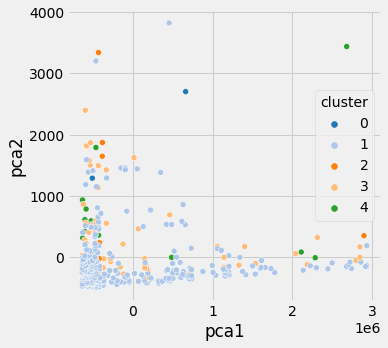

In [68]:
# Scatterplot of our clusters, reduced to two dimensions
plt.figure(figsize=(5,5))
ax= sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df, palette='tab20')
plt.show()

The clusters don't look spheric and they seem to be quite huge. The overlap is caused by dimensionality reduction, I suppose, but I didn't really look into it. Dimensionality reduction isn't necesarry here anyway and it's only used for visualisation purpose.

Variances among features (PCA components)
-----

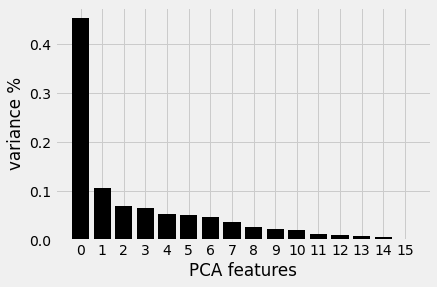

In [69]:
# Standardising and plotting the variances of the features
X_std = StandardScaler().fit_transform(df_poistand.iloc[:, 3:])
pca = PCA(n_components=16)

principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


PCA_components = pd.DataFrame(principalComponents)

The data is as such, that it would even be admissible to reduce it to one dimension (which we know is the trees).

Text(0, 0.5, 'PCA 2')

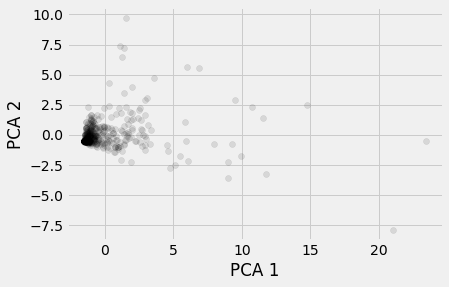

In [70]:
# Plotting the most influencial two features
plt.scatter(PCA_components[0], PCA_components[1], alpha= 0.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Even the two most influencial features would map most datapoints into one dense centre.

Evaluation
---
(This isn't finished at this point, just some thoughts.)

Even though our clusters aren't spheric, k-Means might have been the right choice, because we could make use of it's outlier sensitivity. The main problem is our data.

The data shows one huge cluster of samples groupong around 0, which are the routes that pass by average numbers of points of interest. There are some samples that seem like outliers, but in fact those are the routes that pass by higher numbers of points of interest.

The short term solution we would suggest, was to raise the number of k above what the elbow or the silhouette method would recommend, so we've less samples within the "average cluster" and more in the clusters that reveal actual route characteristics.

As a long term solition we'd suggest to add more data to the existing features.